# Project Name: Salary Prediction

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

In [29]:
df = pd.read_csv('/Users/ranggaakhli/Predicting salary/Salary_Data.csv')

In [30]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


- From general observation, each column has a slightly different number of non-null values, indicating inconsistent missing data.
- Specifically, Salary has the most missing entries (3), while Education Level and Years of Experience each have 1 missing.
- The data types also need adjustment:
    - Gender, Education Level, and Job Title should likely be categorical.
    - Columns like Age and Years of Experience are correctly numerical but may require conversion to integers if appropriate.

In [32]:
df.describe().round()

,Age,Years of Experience,Salary
count,6702.0,6701.0,6699.0
mean,34.0,8.0,115327.0
std,8.0,6.0,52786.0
min,21.0,0.0,350.0
25%,28.0,3.0,70000.0
50%,32.0,7.0,115000.0
75%,38.0,12.0,160000.0
max,62.0,34.0,250000.0


- For Age, Years of Experience, and Salary, the mean is slightly higher than the median, suggesting right-skewed distributions.
- This means a small number of higher values (especially in Salary, with a max of 250,000) may be pulling the average up.
- For example, Salary:
        - Mean = 115,327
        - Median = 115,000
- This small gap hints at mild skewness, but outliers like the minimum of 350 and maximum of 250,000 should be reviewed further.

In [33]:
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [34]:
missing_percent = df.isnull().mean() * 100
missing_df = pd.DataFrame({
    'column_name': missing_percent.index,
    'missing_percentage': missing_percent.values
}).sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)
missing_df


,column_name,missing_percentage
0,Salary,0.074582
1,Education Level,0.044749
2,Years of Experience,0.044749
3,Age,0.029833
4,Gender,0.029833
5,Job Title,0.029833


- All columns have less than 0.1% missing values, with Salary having the highest at 0.075%.
- According to data cleaning best practices, columns with missing percentages below 5% are generally considered safe to drop or impute without significantly impacting analysis.
- Therefore, these missing values can be dropped or imputed as part of preprocessing, since their impact on the dataset is minimal.

In [35]:
#drop missing value
df.dropna(inplace=True)

In [36]:
summary = pd.DataFrame(
    {'column_name': df.columns,
    'n_unique': df.nunique().values,
    'unique_value' : [df[col].unique() for col in df.columns]}
)
summary

,column_name,n_unique,unique_value
0,Age,41,"[32.0, 28.0, 45.0, 36.0, 52.0, 29.0, 42.0, 31...."
1,Gender,3,"[Male, Female, Other]"
2,Education Level,7,"[Bachelor's, Master's, PhD, Bachelor's Degree,..."
3,Job Title,191,"[Software Engineer, Data Analyst, Senior Manag..."
4,Years of Experience,37,"[5.0, 3.0, 15.0, 7.0, 20.0, 2.0, 12.0, 4.0, 1...."
5,Salary,444,"[90000.0, 65000.0, 150000.0, 60000.0, 200000.0..."


In [37]:
df['Education Level'].unique()

array(["Bachelor's", "Master's", 'PhD', "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

Education level column contains inconsistent representations. For instance, "Bachelor's" and "Bachelor's Degree" refer to the same qualification but are labeled differently. Similarly, 'PhD' and 'phD' differ only in letter casing. Such inconsistencies can lead to redundant categories and inaccuracies in data analysis. It's essential to standardize these entries to ensure uniformity and reliability in your dataset.​

In [38]:
df['Education Level'] = df['Education Level'].replace({
    "Bachelor's Degree": "Bachelor's",
    "Master's Degree": "Master's",
    'phD': 'PhD'
})

In [39]:
df['Education Level'].value_counts()

Education Level
Bachelor's     3021
Master's       1860
PhD            1369
High School     448
Name: count, dtype: int64

the largest proportion in education level is bachelor's

In [40]:
df['Gender'].value_counts()

Gender
Male      3671
Female    3013
Other       14
Name: count, dtype: int64

### data distribution viz

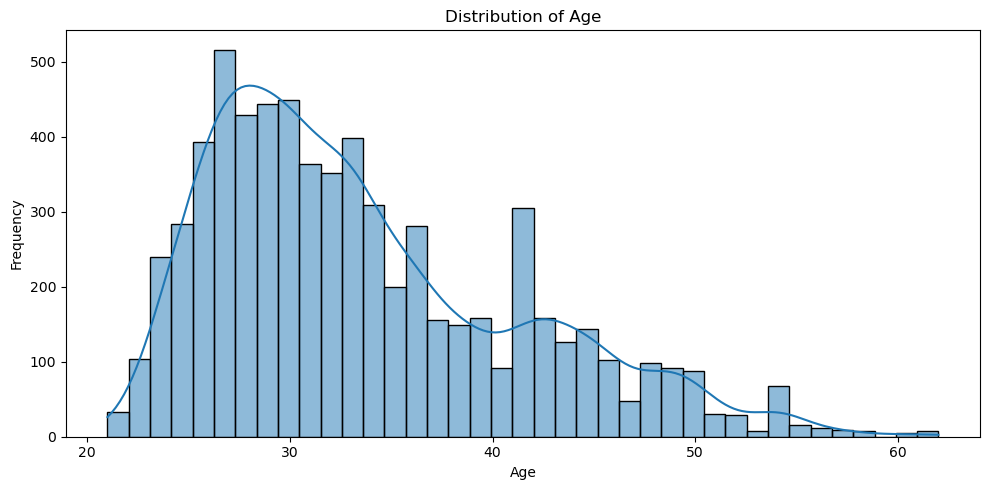

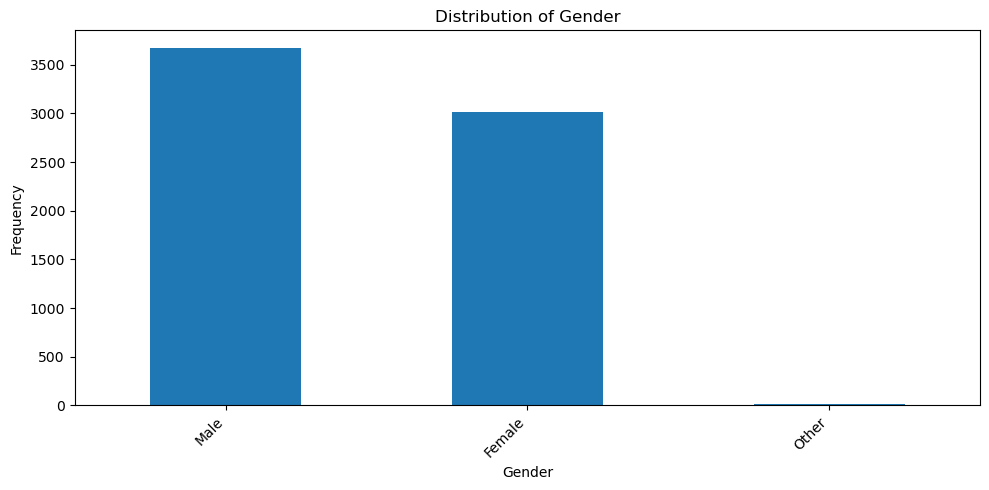

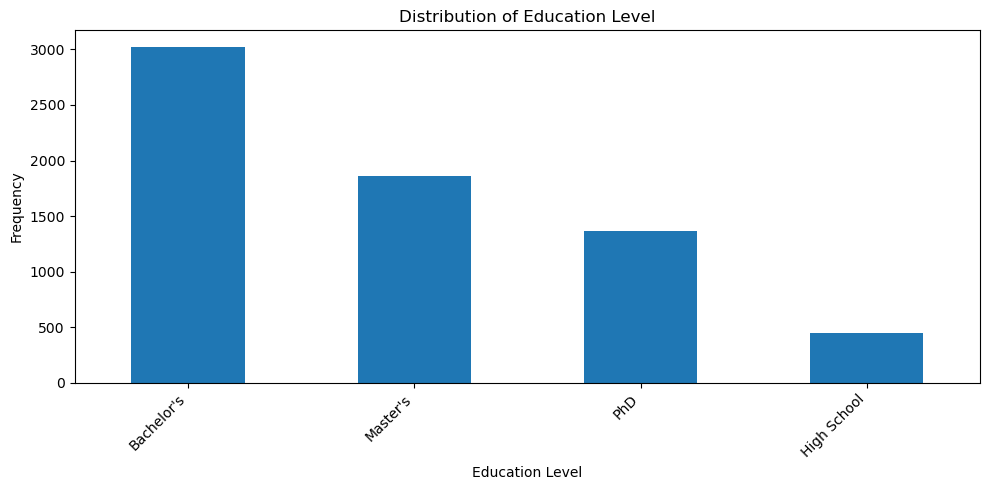

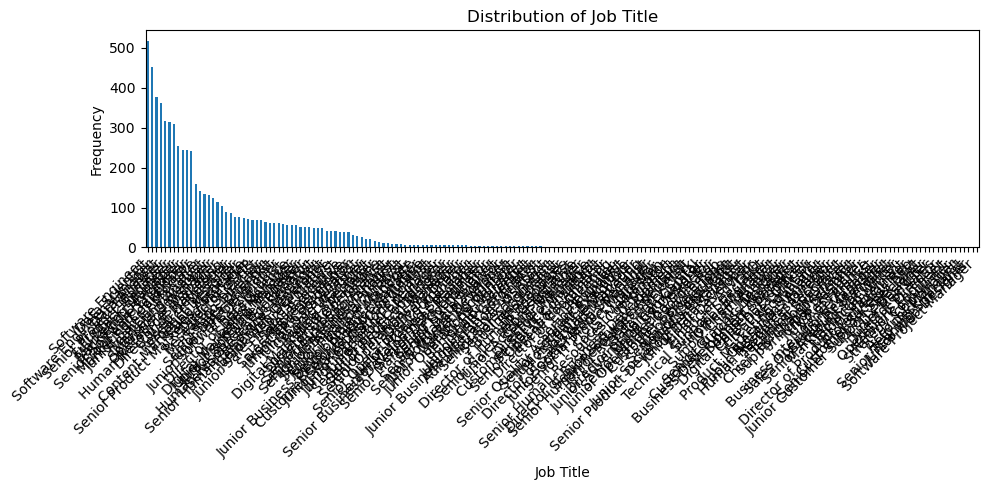

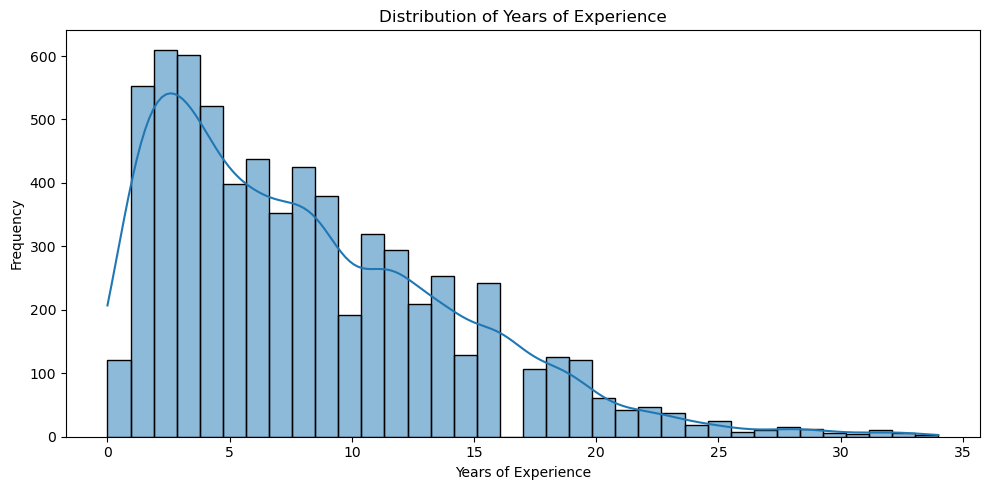

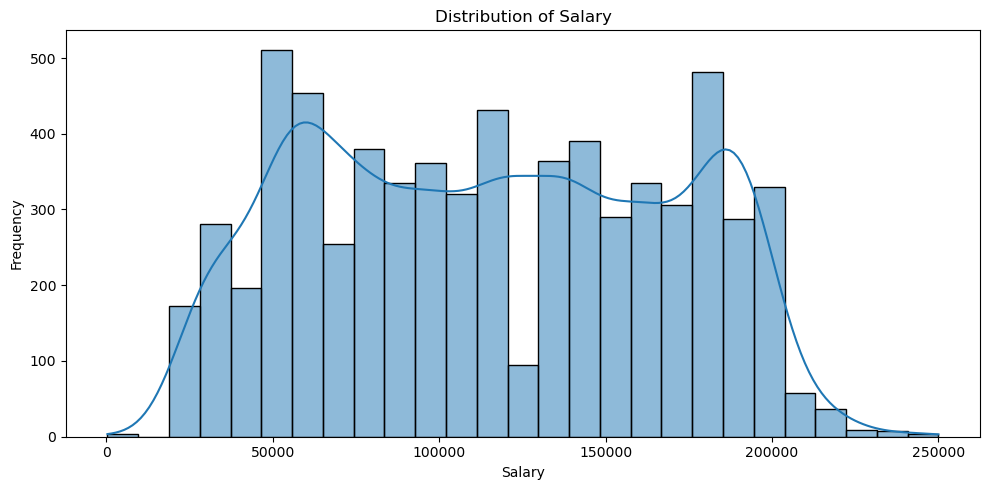

In [41]:
for col in df.columns:
    plt.figure(figsize=(10,5))
    plt.title(f'Distribution of {col}')
    
    if df[col].dtype == 'object':
        df[col].value_counts().plot(kind='bar')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')
    else:
        sns.histplot(df[col], kde=True)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

distributions are commonly skewed, and distribution of salary is bimodal

In [42]:
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Software Project Manager        1
Name: count, Length: 191, dtype: int64

with as many as 191 kind of job title, software engineer and data scientist become the top two

## Correlation

In [43]:
#use spearman corr because distribution is skewed
num_cols = df.select_dtypes(include=['number']).columns
correlation_matrix = df[num_cols].corr(method='spearman')

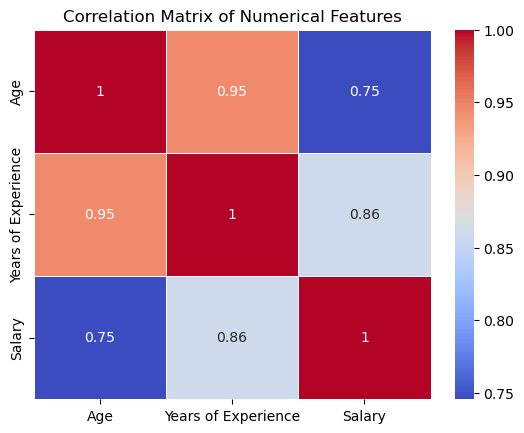

In [44]:
plt.Figure(figsize=(10,5))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

all of the numeric columns have strong positive correlation. it means when one feature increases the rest will follow

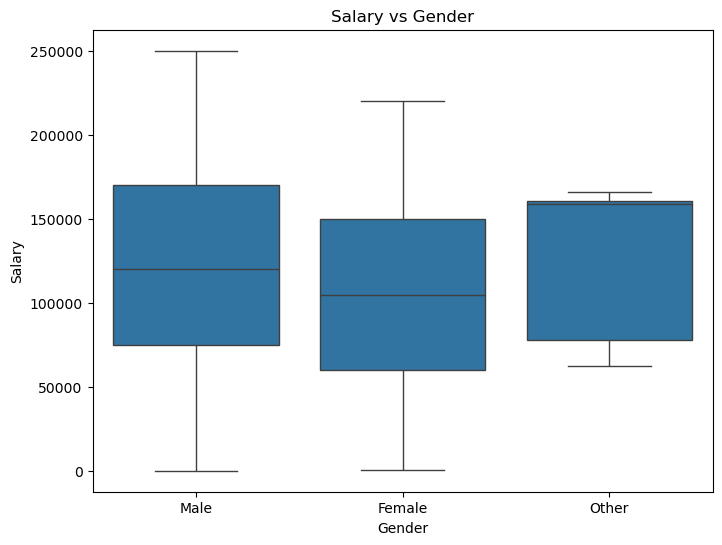

In [45]:
# a. Salary vs Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Salary', data=df)
plt.title('Salary vs Gender')
plt.show()

the median of the 'other' is higher than the other two, male median is higher than female.

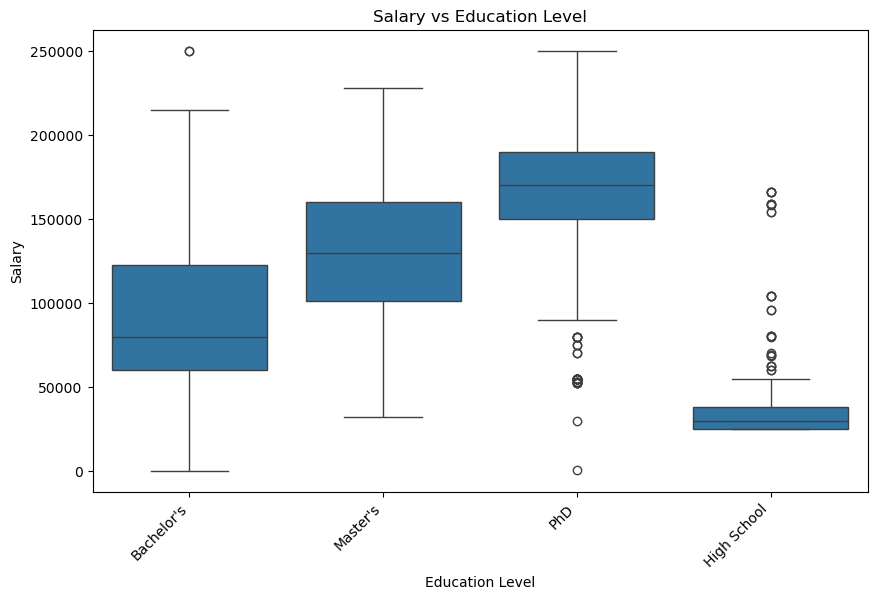

In [46]:
# b. Salary vs Education Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education Level', y='Salary', data=df)
plt.title('Salary vs Education Level')
plt.xticks(rotation=45, ha='right')
plt.show()

- Higher education levels generally correlate with higher median salaries.
- The median salary increases progressively from High School to Bachelor's to Master's to PhD
- Outlier applied, unless in Master's
- We are going to not to exclude the outlier because we will test the data in various model including those who are not sensitive to outlier, like Random Forest and XGBoost

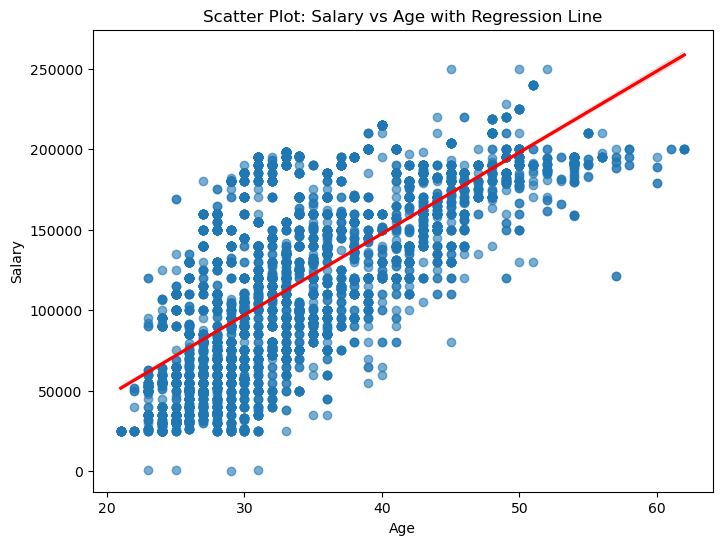

In [47]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Age',
            y='Salary', 
            data=df, 
            scatter_kws={'alpha':0.6}, 
            line_kws={'color': 'red'})
plt.title('Scatter Plot: Salary vs Age with Regression Line')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

- There is a positive relationship between age and salary: older individuals tend to earn more.
- Age is not a perfect predictor of salary, as there is considerable variation in salaries for people of the same age.
- The spread of salaries seems to increase with age.
- The regression line provides a linear approximation of this positive trend.

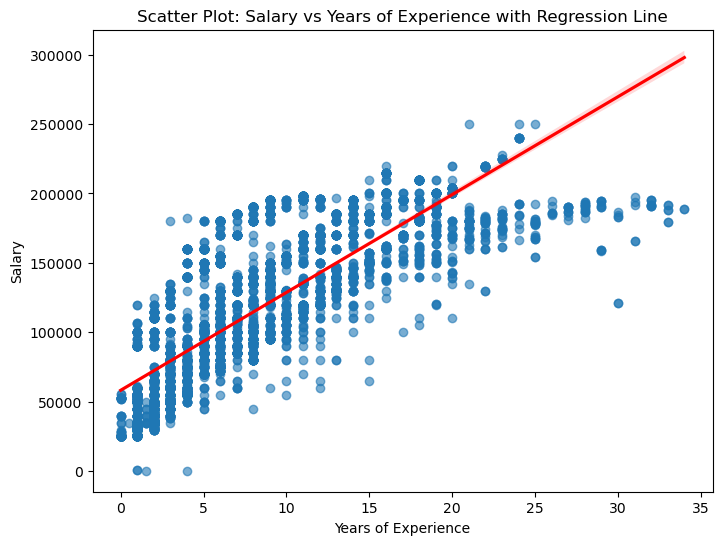

In [48]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Years of Experience',
            y='Salary', data=df, 
            scatter_kws={'alpha':0.6}, 
            line_kws={'color': 'red'})
plt.title('Scatter Plot: Salary vs Years of Experience with Regression Line')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

same as the age above

## Machine Learning, Salary Prediction

### Preprocessing

In [49]:
categorical_features = ['Gender', 'Education Level', 'Job Title']
numerical_features = ['Age', 'Years of Experience']

#### Feature Engineering

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', 
                              sparse_output=False), categorical_features)
    ])

In [51]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Age', 'Years of Experience']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'Education Level', 'Job Title'])])

#### Data splitting: feature selection

In [52]:
X = df.drop('Salary', axis=1)
y = df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #not stratified because it is a regression

### Modelling
the plan: two times tuning, the first one for benchmarking, the second would be taken to compare the best two after fine tuning

In [53]:
#grid search with smaller parameter

model_params = {
    'Linear_Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision_Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'model__max_depth': [2, 4, 6, 8, 10],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Random_Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [10, 50, 100],
            'model__max_depth': [None, 5, 10]
        }
    },
    'Support_Vector_Regression': {
        'model': SVR(),
        'params': {
            'model__kernel': ['linear', 'rbf'],
            'model__C': [0.1, 1, 10]
        }
    },
    'KNN_Regression': {
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    'Elastic_Net': {
        'model': ElasticNet(max_iter=5000),
        'params': {
            'model__alpha': [0.1, 1.0, 5.0],
            'model__l1_ratio': [0.1, 0.5, 0.9]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.1, 0.2]
        }
    }
}

In [54]:

#train the model, look for evaluation and best estimator

results = [] #This list will be used to store the performance metrics and the best trained model (pipeline) along with its best hyperparameters

for model_name, mp in model_params.items():
    print(f"Training and initial model tuning: {model_name}")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])
    params = mp['params']
    #Includes pipeline to ensure that the same preprocessing steps are applied to both the training and testing data, and during the cross-validation process.
    
    if params:
        grid = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_pipeline = grid.best_estimator_
        best_params = grid.best_params_
    else: #Linreg has no parameter
        pipeline.fit(X_train, y_train)
        best_pipeline = pipeline
        best_params = None
    
    #The following preprocessing steps to predict from the pipeline will automatically be applied to the test data before it's fed to the trained model.
    y_pred = best_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100 
    
    print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%\n")
    
    #evaluation score
    results.append({
        'Model': model_name,
        'Pipeline': best_pipeline,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Best_Params': best_params
    })

Training and initial model tuning: Linear_Regression
Linear_Regression - MAE: 22247045449948.1680, MSE: 26528303239186618771140771840.0000, RMSE: 162875115469449.8438, R2: -9303413069157400576.0000, MAPE: 30005258517.80%

Training and initial model tuning: Decision_Tree
Decision_Tree - MAE: 7222.0918, MSE: 152899362.3942, RMSE: 12365.2482, R2: 0.9464, MAPE: 14.82%

Training and initial model tuning: Random_Forest
Random_Forest - MAE: 3209.9503, MSE: 72306522.4057, RMSE: 8503.3242, R2: 0.9746, MAPE: 10.55%

Training and initial model tuning: Support_Vector_Regression
Support_Vector_Regression - MAE: 25944.1886, MSE: 1073863786.2752, RMSE: 32769.8609, R2: 0.6234, MAPE: 40.28%

Training and initial model tuning: KNN_Regression
KNN_Regression - MAE: 3346.1123, MSE: 104190116.5253, RMSE: 10207.3560, R2: 0.9635, MAPE: 10.82%

Training and initial model tuning: Elastic_Net
Elastic_Net - MAE: 17554.9320, MSE: 531883118.9215, RMSE: 23062.5913, R2: 0.8135, MAPE: 25.92%

Training and initial mode

In [55]:
results_df = pd.DataFrame(results)
results_df

,Model,Pipeline,MAE,MSE,RMSE,R2,MAPE,Best_Params
0,Linear_Regression,"(ColumnTransformer(transformers=[('num', Stand...",2.224705e+13,2.652830e+28,1.628751e+14,-9.303413e+18,3.000526e+10,None
1,Decision_Tree,"(ColumnTransformer(transformers=[('num', Stand...",7.222092e+03,1.528994e+08,1.236525e+04,9.463786e-01,1.482321e+01,"{'model__max_depth': 10, 'model__min_samples_s..."
2,Random_Forest,"(ColumnTransformer(transformers=[('num', Stand...",3.209950e+03,7.230652e+07,8.503324e+03,9.746423e-01,1.055054e+01,"{'model__max_depth': None, 'model__n_estimator..."
3,Support_Vector_Regression,"(ColumnTransformer(transformers=[('num', Stand...",2.594419e+04,1.073864e+09,3.276986e+04,6.233985e-01,4.028322e+01,"{'model__C': 10, 'model__kernel': 'linear'}"
4,KNN_Regression,"(ColumnTransformer(transformers=[('num', Stand...",3.346112e+03,1.041901e+08,1.020736e+04,9.634608e-01,1.082409e+01,"{'model__n_neighbors': 5, 'model__weights': 'd..."
5,Elastic_Net,"(ColumnTransformer(transformers=[('num', Stand...",1.755493e+04,5.318831e+08,2.306259e+04,8.134699e-01,2.591605e+01,"{'model__alpha': 0.1, 'model__l1_ratio': 0.9}"
6,XGBoost,"(ColumnTransformer(transformers=[('num', Stand...",6.788761e+03,1.093496e+08,1.045703e+04,9.616514e-01,1.442493e+01,"{'model__learning_rate': 0.2, 'model__max_dept..."


In [56]:
results_df_sorted = results_df.sort_values(['MSE', 'R2'], ascending=[True, False])
results_df_sorted

,Model,Pipeline,MAE,MSE,RMSE,R2,MAPE,Best_Params
2,Random_Forest,"(ColumnTransformer(transformers=[('num', Stand...",3.209950e+03,7.230652e+07,8.503324e+03,9.746423e-01,1.055054e+01,"{'model__max_depth': None, 'model__n_estimator..."
4,KNN_Regression,"(ColumnTransformer(transformers=[('num', Stand...",3.346112e+03,1.041901e+08,1.020736e+04,9.634608e-01,1.082409e+01,"{'model__n_neighbors': 5, 'model__weights': 'd..."
6,XGBoost,"(ColumnTransformer(transformers=[('num', Stand...",6.788761e+03,1.093496e+08,1.045703e+04,9.616514e-01,1.442493e+01,"{'model__learning_rate': 0.2, 'model__max_dept..."
1,Decision_Tree,"(ColumnTransformer(transformers=[('num', Stand...",7.222092e+03,1.528994e+08,1.236525e+04,9.463786e-01,1.482321e+01,"{'model__max_depth': 10, 'model__min_samples_s..."
5,Elastic_Net,"(ColumnTransformer(transformers=[('num', Stand...",1.755493e+04,5.318831e+08,2.306259e+04,8.134699e-01,2.591605e+01,"{'model__alpha': 0.1, 'model__l1_ratio': 0.9}"
3,Support_Vector_Regression,"(ColumnTransformer(transformers=[('num', Stand...",2.594419e+04,1.073864e+09,3.276986e+04,6.233985e-01,4.028322e+01,"{'model__C': 10, 'model__kernel': 'linear'}"
0,Linear_Regression,"(ColumnTransformer(transformers=[('num', Stand...",2.224705e+13,2.652830e+28,1.628751e+14,-9.303413e+18,3.000526e+10,None


the benchmarking process places random forest and KNN regression to be the best two models in terms of MSE and R2. The following step is to fine tune them.

In [57]:
top2_models = results_df_sorted.head(2)
top2_models

,Model,Pipeline,MAE,MSE,RMSE,R2,MAPE,Best_Params
2,Random_Forest,"(ColumnTransformer(transformers=[('num', Stand...",3209.950260,7.230652e+07,8503.324197,0.974642,10.550537,"{'model__max_depth': None, 'model__n_estimator..."
4,KNN_Regression,"(ColumnTransformer(transformers=[('num', Stand...",3346.112309,1.041901e+08,10207.356001,0.963461,10.824091,"{'model__n_neighbors': 5, 'model__weights': 'd..."


### Fine tuning model

In [58]:
#define the best two model, we add parameter more 
fine_tune_params = {
    'Random_Forest': {
        'model__n_estimators': [100, 150, 200],
        'model__max_depth': [10, 15, 20, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'KNN_Regression': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]  # p=1 Manhattan, p=2 Euclidean
    }
}

In [59]:
final_results = []

for idx, row in top2_models.iterrows():
    model_name = row['Model']
    print(f"Fine tuning model: {model_name}")
    
    pipeline = row['Pipeline']
    params = fine_tune_params.get(model_name, {})
    
    if params:
        grid = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=5,
            n_jobs=-1,
            scoring='neg_mean_squared_error'
        )
        grid.fit(X_train, y_train)
        best_pipeline = grid.best_estimator_
        best_params = grid.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_pipeline = pipeline
        best_params = None
    
    y_pred = best_pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # persen
    
    print(f"{model_name} (fine tuning) - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%\n")
    
    final_results.append({
        'Model': model_name,
        'Pipeline': best_pipeline,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Best_Params': best_params
    })


Fine tuning model: Random_Forest
Random_Forest (fine tuning) - MAE: 3391.7291, MSE: 72891994.8497, RMSE: 8537.6809, R2: 0.9744, MAPE: 10.76%

Fine tuning model: KNN_Regression
KNN_Regression (fine tuning) - MAE: 3346.1123, MSE: 104190116.5253, RMSE: 10207.3560, R2: 0.9635, MAPE: 10.82%



In [60]:
final_results_df = pd.DataFrame(final_results)
final_results_df

,Model,Pipeline,MAE,MSE,RMSE,R2,MAPE,Best_Params
0,Random_Forest,"(ColumnTransformer(transformers=[('num', Stand...",3391.729110,7.289199e+07,8537.680882,0.974437,10.758867,"{'model__max_depth': 20, 'model__min_samples_s..."
1,KNN_Regression,"(ColumnTransformer(transformers=[('num', Stand...",3346.112309,1.041901e+08,10207.356001,0.963461,10.824091,"{'model__n_neighbors': 5, 'model__p': 2, 'mode..."


### Save the best model

In [61]:
import joblib

# Make random forest the model choosen

rf_row = final_results_df[final_results_df['Model'] == 'Random_Forest'].iloc[0]

#take the best estimator
rf_pipeline = rf_row['Pipeline']

# save to joblib
joblib.dump(rf_pipeline, 'random_forest_best_pipeline.joblib')
print("Model successfully saved, name: 'random_forest_best_pipeline.joblib'")


Model successfully saved, name: 'random_forest_best_pipeline.joblib'


In [62]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Education Level',
                                                   'Job Title'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=200,
                                       random_state=42))])

### Model Loading and Prediction

In [63]:
import joblib

# Load pipeline
loaded_rf_pipeline = joblib.load('random_forest_best_pipeline.joblib')

# Example
new_data = pd.DataFrame({
    'Gender': ['Female'],
    'Education Level': [""],
    'Job Title': ['Data Analyst'],
    'Age': [28],
    'Years of Experience': [4]
})

# prediction
prediksi = loaded_rf_pipeline.predict(new_data)
print(f"salary prediction: {prediksi[0]:.2f}")


salary prediction: 84993.54


### Feature Importance

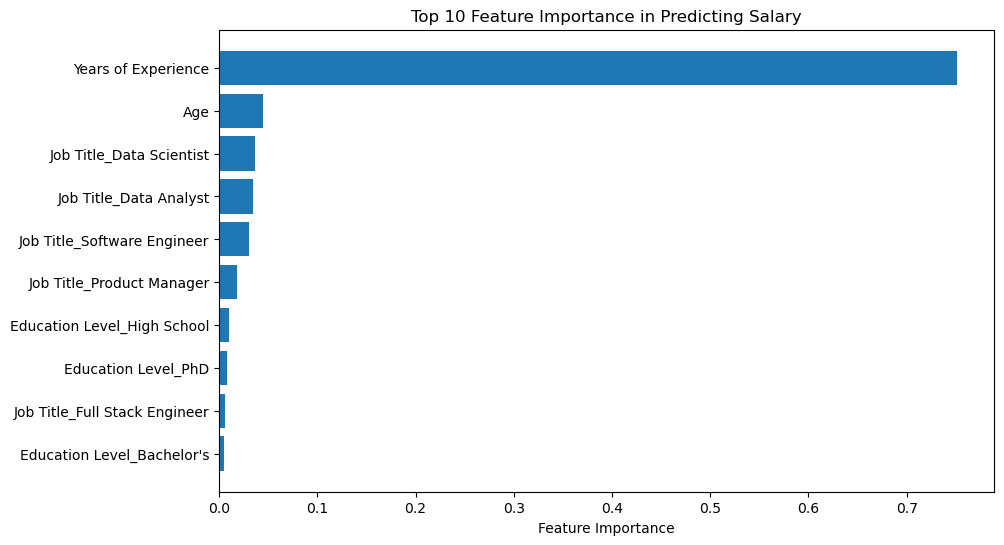

In [64]:
# take model
model = rf_pipeline.named_steps['model']

# make it feature importance
feature_importances = model.feature_importances_

preprocessor = rf_pipeline.named_steps['preprocessor']
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_features) + list(cat_features)

# sort by the highest
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:10][::-1], sorted_feature_importances[:10][::-1])  # dibalik agar fitur terpenting di atas
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance in Predicting Salary')
plt.show()


* Years of Experience: This is by far the most crucial factor in determining salary. A large portion of the salary variation can be explained by how many years of experience a person has.
* Age: Age is the second most important feature, though its influence is considerably less than Years of Experience. This suggests that older individuals tend to earn more, even when controlling for other factors.
* Job Title (Data Scientist, Data Analyst, Software Engineer, Product Manager, Full Stack Engineer): Specific job roles have a noticeable impact on salary. Being a Data Scientist, Data Analyst, Software Engineer, or Product Manager tends to correlate with higher salaries compared to the baseline. Full Stack Engineer has a much smaller positive impact.
* Education Level (High School, PhD, Bachelor's): Education level also plays a role, but its importance is significantly lower than Years of Experience and Age. Having a High School diploma or a PhD seems to have a small impact (the direction isn't explicitly clear from importance alone, but we can infer PhD might be positive and High School negative relative to a baseline), while having a Bachelor's degree has a very minimal impact compared to the other features shown.

In simple terms, when predicting salary based on these features, the model relies most heavily on how many years of experience someone has, followed by their age and then their specific job title. Education level has a comparatively smaller influence among these top 10 features.

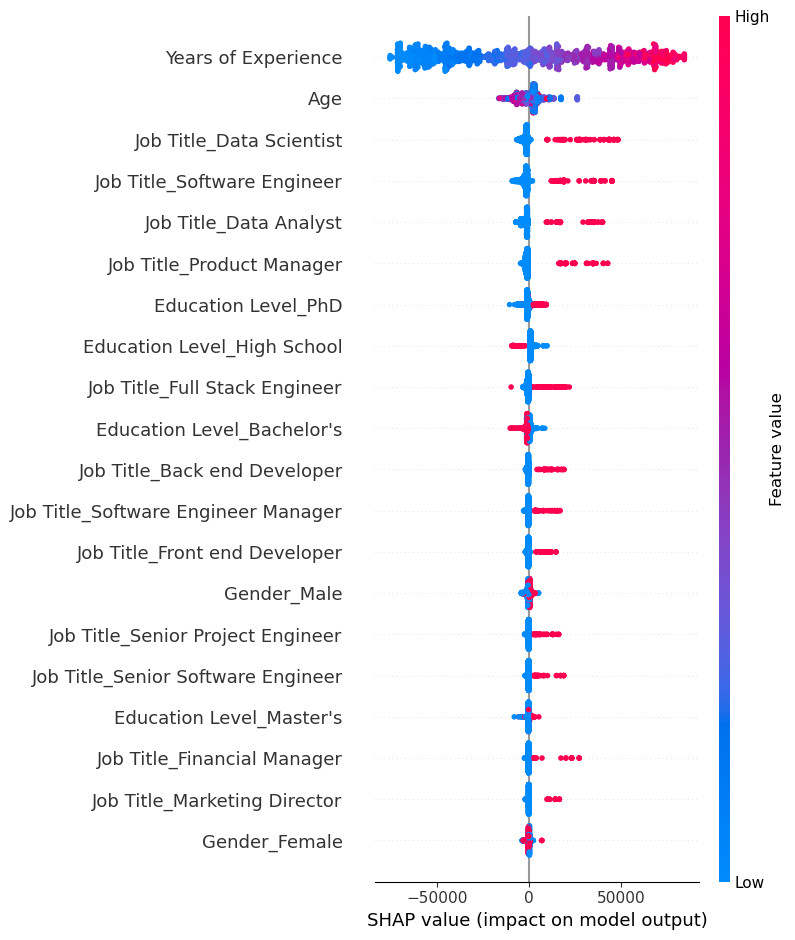

In [65]:
import shap



model = rf_pipeline.named_steps['model']
preprocessor = rf_pipeline.named_steps['preprocessor']

X_test_transformed = preprocessor.transform(X_test)

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_features) + list(cat_features)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)


- the top of Y axis is the most important. In term of the most important, it is ordered from the top
- X axis show the impact. positive to the right and likewise, blue low, red high
- dots represent data point

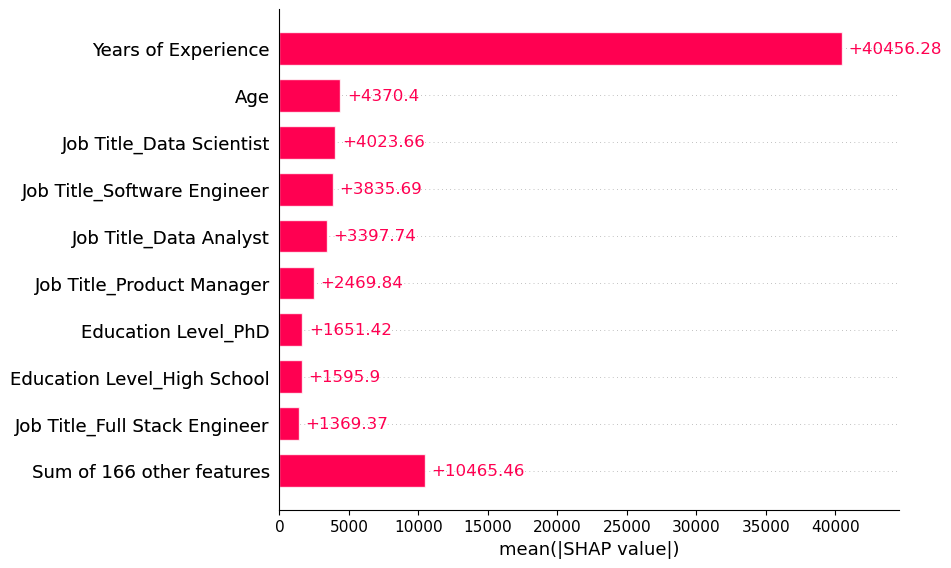

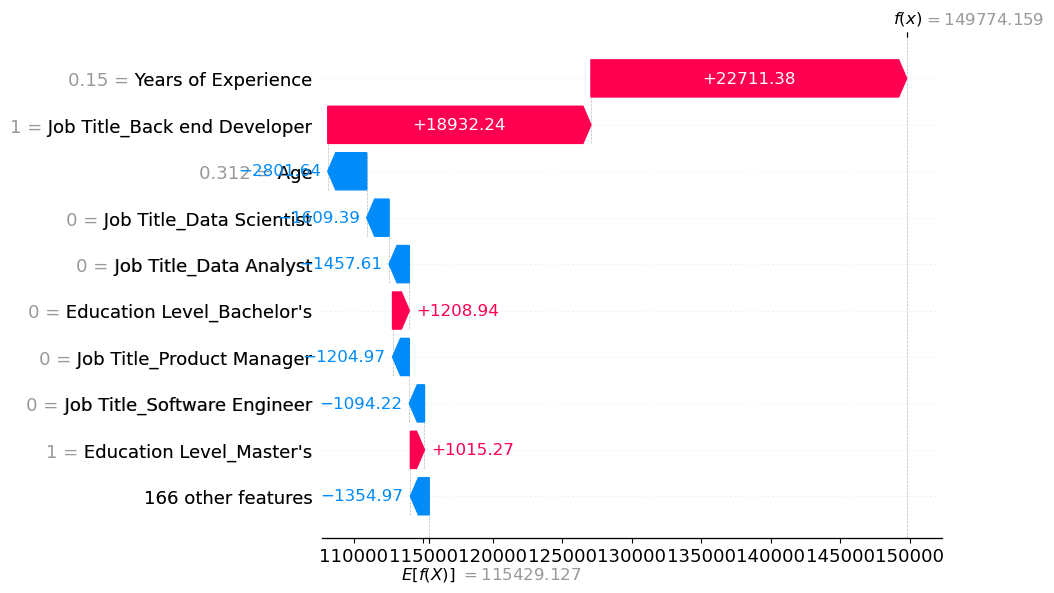

In [66]:
import shap


model = rf_pipeline.named_steps['model']
preprocessor = rf_pipeline.named_steps['preprocessor']

X_test_transformed = preprocessor.transform(X_test)

cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_features) + list(cat_features)

explainer = shap.Explainer(model, feature_names=feature_names)

shap_values = explainer(X_test_transformed)

shap.plots.bar(shap_values, max_display=10)

shap.plots.waterfall(shap_values[0])
